### 1. Import Dependencies and Setup 📥

#### 1.1 Dependencies

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms as tt
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F
from cnn import Net
from utils import save_model, load_model, display_metrics, plot_graphs
from collections import Counter
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve, 
    roc_auc_score
)
from datasetLoader.MergedDataset import MergedDataset, to_device

#### 1.2 Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


#### 1.3 Parameters

Set the parameter *loadExistingModel* to 'True' if you want to load an existing model and specify wich model do you want to use.

In [ ]:
# Define transformations (e.g., resizing, normalization)
transform = tt.Compose([tt.Resize(255),
                        tt.CenterCrop(224),
                        tt.ToTensor(),
                        tt.Normalize(mean=0.4841, std=0.2428, inplace=True) 
                        ])

# Define train and validation split value
train_perc = 0.8

# Define batch size
batch_size = 64

# Define learning rate
learning_rate = 0.0001

# Seed
seed = 2024
torch.manual_seed(seed)

# Model settings
loadExistingModel = True
modelName = "./models/modelRsna.pth"
saveModel = not loadExistingModel

### 2. Load Data 📚

#### 2.1 Dataset loading

In [4]:
dataset = MergedDataset(device, 
                                    transformLoadingRsna=transform, 
                                    chest_xray=False, cheX=False, kaggle_rsna=True,
                                    kaggleRsna_drop_normal_percentage=0.50, 
                                    split_seed=2024)
train_dl, test_dl = dataset.getDataLoader()

Loading dataset...


#### 2.2 Dataset sizes

In [5]:
print(f'Merged dataset lenght: {dataset.getSize()}')

Merged dataset lenght: 19891


#### 2.3 Dataset classes

In [6]:
train_class_count = dataset.getTrainClasses()
test_class_count = dataset.getTestClasses()

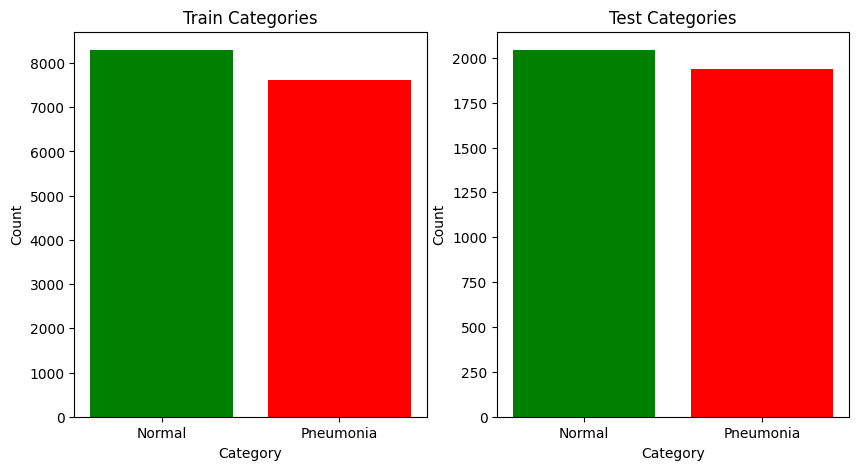

Train classes:
	Normal:		8293
	Pneumonia:	7620
Test classes:
	Normal:		2043
	Pneumonia:	1935


In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

values = [train_class_count[0], train_class_count[1], test_class_count[0], test_class_count[1]]

# Data for the categories
categories = ['Normal', 'Pneumonia']

for i in range(2):
    # Create the bar chart
    ax[i].bar(categories, [values[0 + i*2], values[1 + i*2]], color=['green', 'red'])
    # Add titles and labels
    ax[i].set_title('Train Categories' if i == 0 else 'Test Categories')
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Category')

# Show the plot
plt.show()

print(f'Train classes:\n\tNormal:\t\t{train_class_count[0]}\n\tPneumonia:\t{train_class_count[1]}')
print(f'Test classes:\n\tNormal:\t\t{test_class_count[0]}\n\tPneumonia:\t{test_class_count[1]}')

#### 2.4 Data Samples

In [8]:
batch = next(iter(train_dl))
images, labels = batch
print(f'Image shape: {images[0].shape}\nLabel shape: {labels[0]}')

Image shape: torch.Size([3, 224, 224])
Label shape: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9938221..1.8502196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9938221..1.1395565].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9938221..1.8340682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9292164..1.8179168].


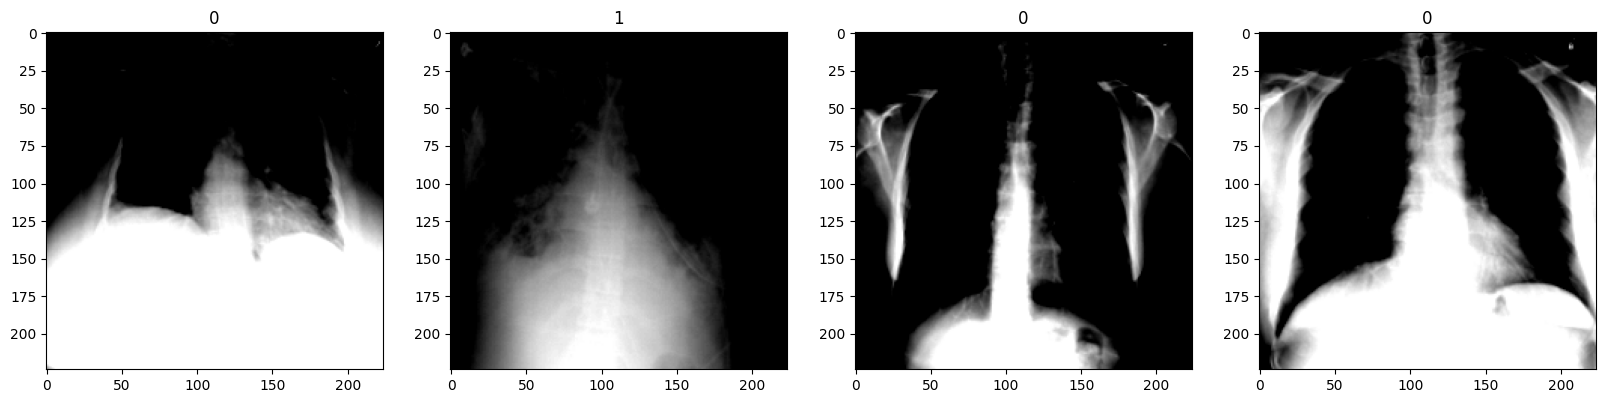

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.cpu().permute(1, 2, 0))
    ax[idx].title.set_text(batch[1][idx].cpu().numpy())

### 5. Model Building 🏗️

#### 5.1 Train Model

In [ ]:
trained = False
net = None

if loadExistingModel:
    net = load_model(modelName)

if net == None:
    print('The model does not exist!\nCreating and training model...')
    net = to_device(Net(), device)

    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Define weights for the cross entropy loss
    weight = torch.FloatTensor([train_class_count[1]/(train_class_count[0]+train_class_count[1]), train_class_count[0]/(train_class_count[0]+train_class_count[1])]).to(device)

    # Train the model
    loss_values = []
    net.train()
    trained = True
    for epoch in range(50):
        running_loss = 0.0
        for i, data in enumerate(train_dl, 0):
            inputs, labels = data
            inputs, labels = to_device(inputs, device), to_device(labels, device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = F.cross_entropy(outputs, labels, weight=weight)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        loss_values.append(running_loss / len(train_dl))
        print(f'Epoch: {epoch}, loss: {(running_loss / len(train_dl))}')
else:
    print('The model exist and exists and has been loaded')
    trained = False
    net.to(device)
    net.eval()
    print('Model info:')
    for param_tensor in net.state_dict():
        print("\t", param_tensor, "\t", net.state_dict()[param_tensor].size())

The model exist and exists and has been loaded
Model info:
	 conv_layers.0.weight 	 torch.Size([3, 3, 3, 3])
	 conv_layers.0.bias 	 torch.Size([3])
	 conv_layers.3.weight 	 torch.Size([6, 3, 3, 3])
	 conv_layers.3.bias 	 torch.Size([6])
	 conv_layers.6.weight 	 torch.Size([9, 6, 3, 3])
	 conv_layers.6.bias 	 torch.Size([9])
	 conv_layers.9.weight 	 torch.Size([12, 9, 3, 3])
	 conv_layers.9.bias 	 torch.Size([12])
	 conv_layers.12.weight 	 torch.Size([15, 12, 3, 3])
	 conv_layers.12.bias 	 torch.Size([15])
	 conv_layers.15.weight 	 torch.Size([16, 15, 3, 3])
	 conv_layers.15.bias 	 torch.Size([16])
	 fc_layers.0.weight 	 torch.Size([64, 144])
	 fc_layers.0.bias 	 torch.Size([64])
	 fc_layers.3.weight 	 torch.Size([64, 64])
	 fc_layers.3.bias 	 torch.Size([64])
	 fc_layers.6.weight 	 torch.Size([2, 64])
	 fc_layers.6.bias 	 torch.Size([2])


#### 5.2 Save Model

In [11]:
if saveModel:
    save_model(modelName, net)

#### 5.3 Plot Loss 📈

In [12]:
if trained:
    plt.figure(figsize=(8, 6))
    plt.plot(loss_values, marker='o', label='Loss')
    plt.title('Loss Values Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()

### 7. Testing Model 🧪

#### 7.1 Test on kaggle-rsna

##### 7.1.1 Test

In [13]:
# Test the model
y_test = []
prob = []
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = to_device(images, device), to_device(labels, device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test.extend(labels.cpu().numpy())
        prob.extend(torch.nn.functional.softmax(outputs.cpu(), dim=1)[:, 1])
    fprRsna, tprRsna, thresholds = roc_curve(y_test, prob)
    roc_aucRsna = roc_auc_score(y_test, prob)

    distances = np.sqrt(fprRsna**2 + (1 - tprRsna)**2)
    best_threshold = thresholds[np.argmin(distances)]
    new_preds = [1 if score > best_threshold else 0 for score in prob]

    cm = confusion_matrix(y_test, new_preds)
    dispRsna = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE"])
    accuracyRsna = accuracy_score(y_test, new_preds)
    precisionRsna = precision_score(y_test, new_preds)
    recallRsna = recall_score(y_test, new_preds)
    f1Rsna = f1_score(y_test, new_preds)

#### 7.2 Test on cheX

##### 7.2.0 Load Dataset

In [14]:
transform = tt.Compose([tt.Resize(255),
                        tt.CenterCrop(224),
                        tt.ToTensor(),
                        tt.Normalize(mean=0.5017, std=0.2905, inplace=True)
                        ])

dataset = MergedDataset(device, 
                                    transformLoadingCheX=transform, 
                                    chest_xray=False, cheX=True, kaggle_rsna=False, 
                                    train_percentage=0,
                                    split_seed=2024)
_, test_dl = dataset.getDataLoader()

Loading dataset...


##### 7.2.1 Test

In [15]:
# Test the model
y_test = []
prob = []
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = to_device(images, device), to_device(labels, device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test.extend(labels.cpu().numpy())
        prob.extend(torch.nn.functional.softmax(outputs.cpu(), dim=1)[:, 1])
    fprCheX, tprCheX, thresholds = roc_curve(y_test, prob)
    roc_aucCheX = roc_auc_score(y_test, prob)

    distances = np.sqrt(fprCheX**2 + (1 - tprCheX)**2)
    best_threshold = thresholds[np.argmin(distances)]
    new_preds = [1 if score > best_threshold else 0 for score in prob]

    cm = confusion_matrix(y_test, new_preds)
    dispCheX = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE"])
    accuracyCheX = accuracy_score(y_test, new_preds)
    precisionCheX = precision_score(y_test, new_preds)
    recallCheX = recall_score(y_test, new_preds)
    f1CheX = f1_score(y_test, new_preds)

#### 7.3 Test on chest_xray-3

##### 7.3.0 Load dataset

In [16]:
transform = tt.Compose([tt.Resize(255),
                        tt.CenterCrop(224),
                        tt.ToTensor(),
                        tt.Normalize(mean=0.482, std=0.236, inplace=True)
                        ])

dataset = MergedDataset(device, 
                                    transformLoadingChest=transform,
                                    chest_xray=True, cheX=False, kaggle_rsna=False, 
                                    train_percentage=0)
_, test_dl = dataset.getDataLoader()

##### 7.3.1 Test

In [17]:
# Test the model
y_test = []
prob = []
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = to_device(images, device), to_device(labels, device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test.extend(labels.cpu().numpy())
        prob.extend(torch.nn.functional.softmax(outputs.cpu(), dim=1)[:, 1])
    fprChest, tprChest, thresholds = roc_curve(y_test, prob)
    roc_aucChest = roc_auc_score(y_test, prob)

    distances = np.sqrt(fprChest**2 + (1 - tprChest)**2)
    best_threshold = thresholds[np.argmin(distances)]
    new_preds = [1 if score > best_threshold else 0 for score in prob]

    cm = confusion_matrix(y_test, new_preds)
    dispChest = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE"])
    accuracyChest = accuracy_score(y_test, new_preds)
    precisionChest = precision_score(y_test, new_preds)
    recallChest = recall_score(y_test, new_preds)
    f1Chest = f1_score(y_test, new_preds)

#### 7.4 Results

##### 7.4.1 Metrics

In [18]:
display_metrics('RSNA', 'CXr', [roc_aucChest, accuracyChest, precisionChest, recallChest, f1Chest])
display_metrics('RSNA', 'CheX', [roc_aucCheX, accuracyCheX, precisionCheX, recallCheX, f1CheX])
display_metrics('RSNA', 'RSNA', [roc_aucRsna, accuracyRsna, precisionRsna, recallRsna, f1Rsna])

print([roc_aucChest, accuracyChest, precisionChest, recallChest, f1Chest, roc_aucCheX, accuracyCheX, precisionCheX, recallCheX, f1CheX, roc_aucRsna, accuracyRsna, precisionRsna, recallRsna, f1Rsna])


Model trained on	RSNA
Model tested on		CXr
Metrics:
	Auroc:		0.8663029653797316
	Accuracy:	0.7906420765027322
	Precision:	0.9085545722713865
	Recall:		0.7928855604961386
	F1:		0.846788302924269

Model trained on	RSNA
Model tested on		CheX
Metrics:
	Auroc:		0.652247012143888
	Accuracy:	0.615716683987529
	Precision:	0.5970078740157481
	Recall:		0.6277529392283491
	F1:		0.6119945112599887

Model trained on	RSNA
Model tested on		RSNA
Metrics:
	Auroc:		0.8513934895862976
	Accuracy:	0.7719959778783309
	Precision:	0.7625127681307456
	Recall:		0.7715762273901808
	F1:		0.7670177241202157
[np.float64(0.8663029653797316), 0.7906420765027322, np.float64(0.9085545722713865), np.float64(0.7928855604961386), np.float64(0.846788302924269), np.float64(0.652247012143888), 0.615716683987529, np.float64(0.5970078740157481), np.float64(0.6277529392283491), np.float64(0.6119945112599887), np.float64(0.8513934895862976), 0.7719959778783309, np.float64(0.7625127681307456), np.float64(0.7715762273901808), np.

##### 7.4.2 Graphs

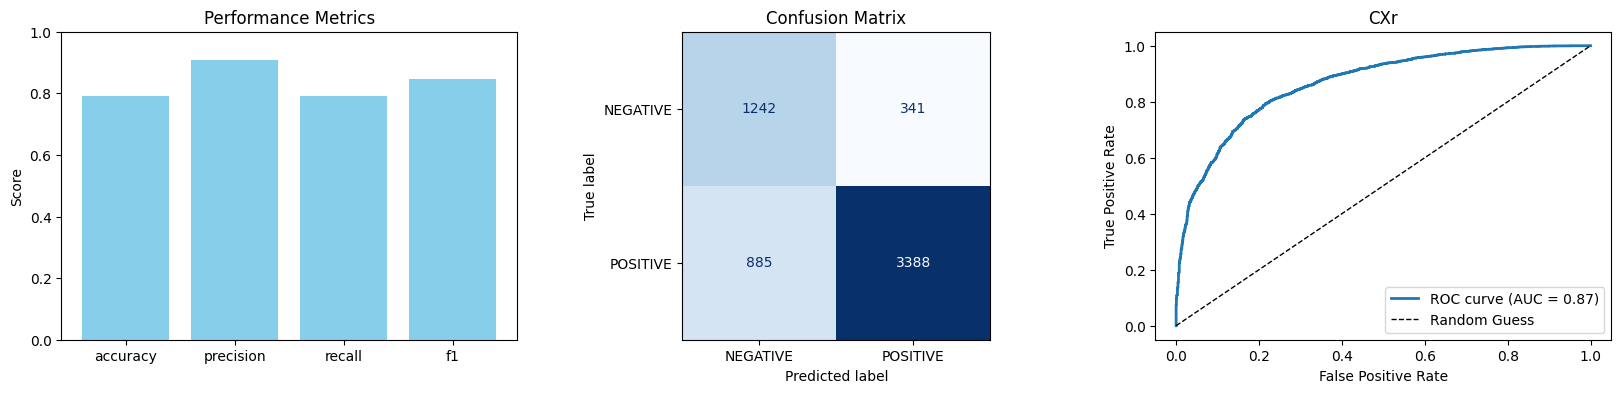

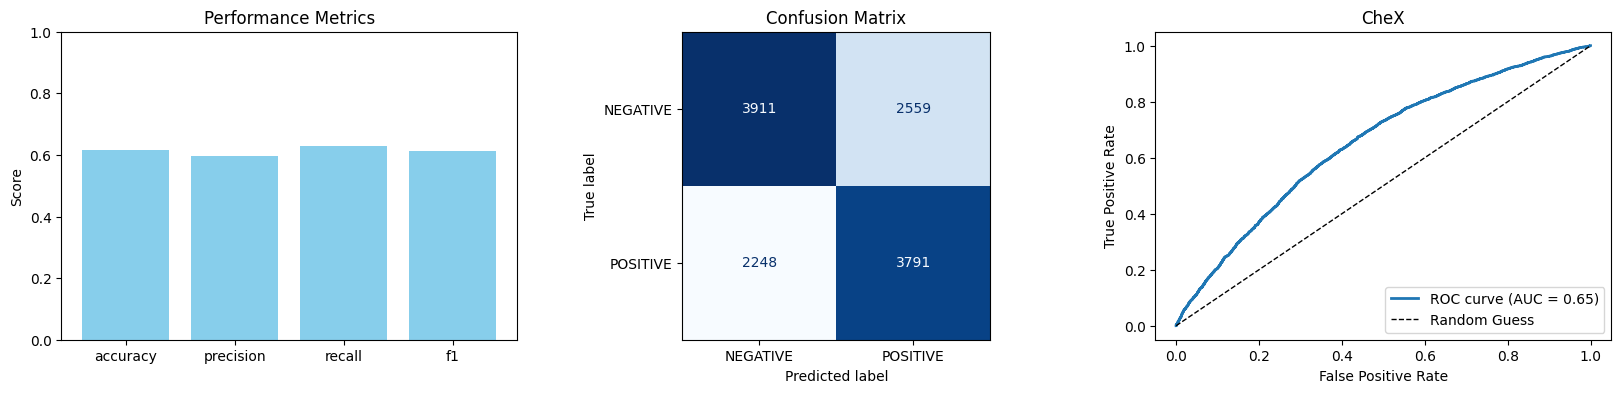

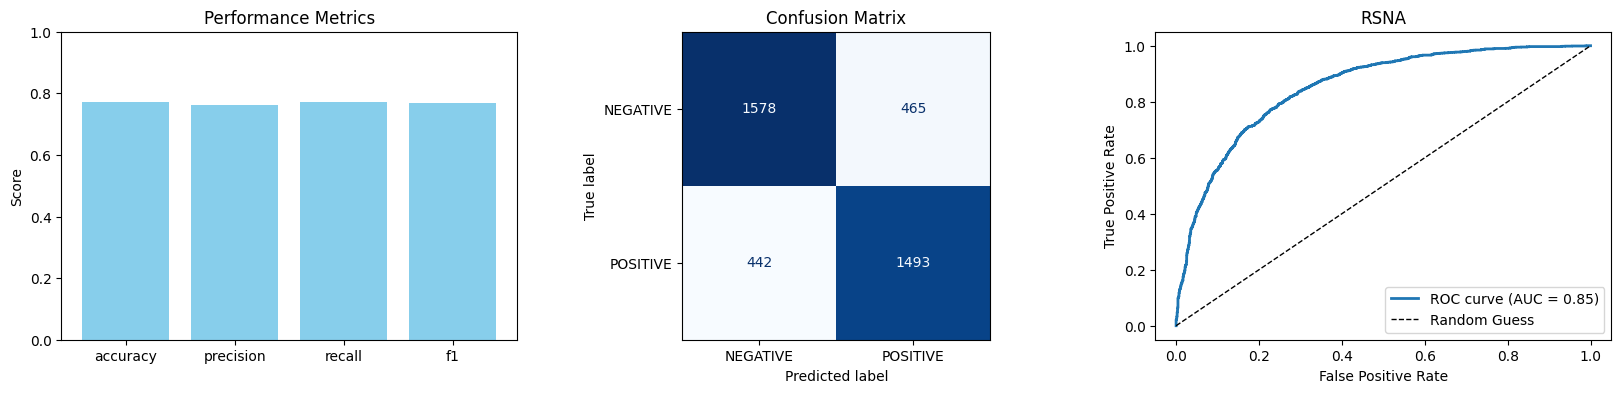

In [19]:
plot_graphs('CXr', roc_aucChest, fprChest, tprChest, dispChest, [accuracyChest, precisionChest, recallChest, f1Chest])
plot_graphs('CheX', roc_aucCheX, fprCheX, tprCheX, dispCheX, [accuracyCheX, precisionCheX, recallCheX, f1CheX])
plot_graphs('RSNA', roc_aucRsna, fprRsna, tprRsna, dispRsna, [accuracyRsna, precisionRsna, recallRsna, f1Rsna])